## DATA 620: Project 3 – Name-Gender Classifier

***
>### Bryant Chang, Tom Detzel, Sandipayan Nandi, Erik Nylander
>### Oct. 31, 2016  
  
***


### Contents
- [Introduction and Results](#intro) 
- [1. Creating the training, dev_test, and test sets – nltk names corpus](#section1)  
- [2. Building Feature Sets – Characters and Syllables](#section2)  
- [3. Building a classifier based on naive Bayes](#section3)
- [4. Building a decision tree classifier](#section4)
- [5. Classifiers using a gender index from Social Security name records](#section5)
- [Appendix A: Preparation of Social Security Names Data](#appendix)



In [1]:
import nltk, re, pprint
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.collocations import BigramCollocationFinder
from collections import Counter
from itertools import *
import codecs
import urllib2
import sys
import os
import string
import random

import itertools as it
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import matplotlib.colors as colors
%matplotlib inline
plot.rcParams['figure.figsize'] = (21, 14)
from scipy.stats import rankdata

# Python 2 users only
from __future__ import division  
from __future__ import unicode_literals

<a id='intro'></a>
# Introduction and Results

**Assignment and Methods:** This project challenged our team to predict gender based on a person's first name. To experiment, we used two approaches involving different data sets. In the first approach, we analyzed first names in the nltk names corpus and created four feature sets based on character position, type of character (vowel) and syllable count. We used naive Bayes and decision tree classifiers to evaluate performance of the feature sets. In the second approach, we analyzed first names in the [Social Security Adminstration's names database](https://www.ssa.gov/oact/babynames/limits.html) and incorporated a gender index [\(see Liu, Ruth, AAAI 2013\)](http://www.aaai.org/ocs/index.php/SSS/SSS13/paper/view/5744/5908 "What’s in a Name? Using First Names
as Features for Gender Inference in Twitter") into our feature sets based on the frequency of name and gender. The index ranges from -1 (always female) to +1 (always male) for every name (nearly 90,000) in the data for the years 1950 to 2015. We added the index to the feature sets created in our initial approach and compared the results. Names were randomized and split into training, development and test sets.

**Findings:** Results showed that our initial feature sets were able to correctly predict gender ~77 percent to ~81 percent of the time on the nltk names corpus and that adding a syllable counter to the feature set achieved the highest accuracy using a decision tree. Using a gender index dramatically increased accuracy to ~96 percent on the Social Security names corpus. Removing the gender index from feature sets also reduced the accuracy by about 12 percentage points. The large size of the Social Security database may have helped improve performance.

**Discussion:** While the gender index results are encouraing, the approach produce a notable pattern of misclassifications: All were females misidentified as males. As noted below, this may reflect the high base rate of female names in the data (ratio: 1.7 to 1) as well as the naive Bayes methodology, which assumes features are independent and melds the influence of each feature combination when predicting a label.


#### Summary of Accuracy Results

Feature set – nltk names corpus   *(N = 7,944)* | Naive Bayes | Decision Tree
-|:-:|:-:
last char| .77 | .77 
last char, last two chars, last is vowel| .77 | .80 
first char, last two chars, last is vowel| .77 | --
last char, last two chars, last is vowel, sylablle count| .77 | .814

Feature set – Social Security names   *(N = 88,860)* | Naive Bayes | Decision Tree
-|:-:|:-:
last char, gender index| .97 | .95
last char, last two chars, last is vowel, gender index| .96 | --
last char, last two chars, last is vowel| .96 | --
first char, last two chars, last is vowel, gender index| .84| --
last char, last two chars, last is vowel, sylablle count, gender index| .97 | .94 

***
***

<a id='section1'></a>
## 1. Creating the training, dev_test, and test sets – nltk names corpus

### 1.1 Import, randomly shuffle names, divide data

In [2]:
## note that seed is set
import random
from nltk.corpus import names
random.seed(1234) # for reproducibility
names = ([(name, 'male') for name in names.words('male.txt')] +
         [(name, 'female') for name in names.words('female.txt')])
random.shuffle(names) 

test_names = names[:500]
devtest_names = names[500:1000]
train_names = names[1000:]

#### Count of test, development, training names

In [3]:
print len(test_names), len(devtest_names), len(train_names), len(names)

500 500 6944 7944



#### Examine names list

In [4]:
names[0:5]

[(u'Garwin', u'male'),
 (u'Cindie', u'female'),
 (u'Juanita', u'male'),
 (u'Dael', u'female'),
 (u'Jillayne', u'female')]

<a id='section2'></a>
## 2. Building Feature Sets – Characters and Syllables

### 2.1 Helper function to count syllables

In [5]:
# Count the number of syllables in a word
def count_syllables(word):
    vowels = 'aeiouy'
    word = word.lower()
    count = 0
    if word[0] in vowels:
        count += 1
    for i in range(1, len(word)):
        if word[i] in vowels and word[i-1] not in vowels:
            count += 1
    if word.endswith('e'):
        count -= 1
    if word.endswith('le'):
        count += 1
    if word.endswith('bile'):
        count -= 1
    if count == 0:
        count += 1
    return count

### 2.2 Baseline feature set

Includes only last character of word.

In [6]:
## baseline feature set: to check others against minimum performance
def baseFeatures(name):
    name=name.lower()
    return {
        'last_letter': name[-1]
        }

In [7]:
baseFeatures('Shrek')

{u'last_letter': u'k'}

### 2.3 Feature set 2  
Adds last two characters as suffix and whether last letter is a vowel.

In [8]:
## adds last vowel and last 2 char suffix
def gender_features2(word):
    return {'suffix1': word[-1],
            'suffix2': word[-2:],
            'last_is_vowel' : (word[-1] in 'aeiouy')}

### 2.4 Feature set 3
First letter, suffix of last two characters, last letter is vowel.

In [9]:
## uses first letter instead of last letter; keeps last vowel and last 2 char suffix
def gender_features3(word):
    return {'first_letter': word[0],
            'suffix': word[-2:],
            'last_is_vowel' : (word[-1] in 'aeiouy')}

In [10]:
gender_features3('Shrek')

{u'first_letter': u'S', u'last_is_vowel': False, u'suffix': u'ek'}

### 2.5 Feature set 4
Adds syllable count to feature set 2.

In [11]:
## adds a syllable count to the feature set
def gender_features4(word):
    return {
        'last_letter': word[-1],
        'last_two': word[-2:],
        'last_is_vowel': (word[-1] in 'aeiouy'),
        'num_syll': count_syllables(word)
    }

In [12]:
gender_features4('superman')

{u'last_is_vowel': False,
 u'last_letter': u'n',
 u'last_two': u'an',
 u'num_syll': 3}

<a id='section3'></a>
## 3. Building a classifier based on naive Bayes

We start with the *baseFeatures* set only examining last character in name, then compare to *gender_features* versions that include last two characters, whether last character is a vowel and a syllable count.

### 3.1 Base featureset, last letter only
#### Development set accuracy = 0.752

In [13]:
## baseFeatures
train_set = [(baseFeatures(n), g) for (n,g) in train_names]
devtest_set = [(baseFeatures(n), g) for (n,g) in devtest_names]
test_set = [(baseFeatures(n), g) for (n,g) in test_names]
nbclassifier = nltk.NaiveBayesClassifier.train(train_set) 
print nltk.classify.accuracy(nbclassifier, devtest_set)

0.752


#### Test set accuracy = 0.77

In [14]:
nb1 = nltk.classify.accuracy(nbclassifier, test_set)
print nb1

0.77


### 3.2 Featureset 2, adding last two suffix, last is vowel
#### Marginal improvement in accuracy = 0.766

In [15]:
## gender_features set
train_set = [(gender_features2(n), g) for (n,g) in train_names]
devtest_set = [(gender_features2(n), g) for (n,g) in devtest_names]
test_set = [(gender_features2(n), g) for (n,g) in test_names]
nbclassifier2 = nltk.NaiveBayesClassifier.train(train_set) 
print nltk.classify.accuracy(nbclassifier2, devtest_set)

0.766


#### Test set accuracy = 0.772

In [16]:
print nltk.classify.accuracy(nbclassifier2, test_set)

0.772


### 3.3 Featureset 3, swap first letter for last letter
#### Development set accuracy = 0.764

In [17]:
train_set = [(gender_features3(n), g) for (n,g) in train_names]
devtest_set = [(gender_features3(n), g) for (n,g) in devtest_names]
test_set = [(gender_features3(n), g) for (n,g) in test_names]
nbclassifier3 = nltk.NaiveBayesClassifier.train(train_set) 
print nltk.classify.accuracy(nbclassifier3, devtest_set)

0.774


#### Test set accuracy = 0.77

In [18]:
print nltk.classify.accuracy(nbclassifier3, test_set)

0.772


### 3.4 Featureset 4, adding syllable count to featureset 2
#### Development set  accuracy = 0.764

In [19]:
train_set = [(gender_features4(n), g) for (n,g) in train_names]
devtest_set = [(gender_features4(n), g) for (n,g) in devtest_names]
test_set = [(gender_features4(n), g) for (n,g) in test_names]
nbclassifier4 = nltk.NaiveBayesClassifier.train(train_set) 
print nltk.classify.accuracy(nbclassifier4, devtest_set)

0.764


#### Test set accuracy = 0.77

In [20]:
print nltk.classify.accuracy(nbclassifier4, test_set)

0.77


### 3.5 Error review, featureset 2

Errors are mostly of two types: (1) Misclassification of females as male based on the last two characters; and (2) misclassifcation of males as female based on last is vowel or 'y'.

In [21]:
errors = []
for (name, tag) in devtest_names:
    guess = nbclassifier2.classify(gender_features2(name))
    if guess != tag:
        errors.append((tag, guess, name))

for (tag, guess, name) in sorted(errors):
    print 'correct=%-8s guess=%-8s name=%-30s' %(tag, guess, name)

correct=female   guess=male     name=Aimil                         
correct=female   guess=male     name=Alys                          
correct=female   guess=male     name=Amargo                        
correct=female   guess=male     name=Ambur                         
correct=female   guess=male     name=Annabell                      
correct=female   guess=male     name=Arabel                        
correct=female   guess=male     name=Beitris                       
correct=female   guess=male     name=Beulah                        
correct=female   guess=male     name=Blair                         
correct=female   guess=male     name=Brigid                        
correct=female   guess=male     name=Brit                          
correct=female   guess=male     name=Carmon                        
correct=female   guess=male     name=Delores                       
correct=female   guess=male     name=Deloris                       
correct=female   guess=male     name=Denys      

In [22]:
nbclassifier.show_most_informative_features(10)

Most Informative Features
             last_letter = u'a'           female : male   =     42.4 : 1.0
             last_letter = u'k'             male : female =     29.8 : 1.0
             last_letter = u'f'             male : female =     14.6 : 1.0
             last_letter = u'v'             male : female =     11.2 : 1.0
             last_letter = u'm'             male : female =     11.0 : 1.0
             last_letter = u'p'             male : female =     10.5 : 1.0
             last_letter = u'd'             male : female =     10.2 : 1.0
             last_letter = u'o'             male : female =      8.1 : 1.0
             last_letter = u'r'             male : female =      7.2 : 1.0
             last_letter = u'g'             male : female =      5.9 : 1.0


<a id='section4'></a>
## 4. Building a decision tree classifier  

We compare the baseline feature set with the best-performing features from prior analysis.

### 4.1 Decison tree with base featureset
#### Development set accuracy = 0.754

In [23]:
train_set = [(baseFeatures(n), g) for (n,g) in train_names]
devtest_set = [(baseFeatures(n), g) for (n,g) in devtest_names]
test_set = [(baseFeatures(n), g) for (n,g) in test_names]
dtclassifier = nltk.classify.DecisionTreeClassifier.train(train_set, entropy_cutoff=0,support_cutoff=0)
print nltk.classify.accuracy(dtclassifier, devtest_set)

0.754


#### Test set accuracy = 0.768

In [24]:
print nltk.classify.accuracy(dtclassifier, test_set)

0.768


### 4.2 Decision tree with featureset 2
#### Development set accuracy = 0.774

In [25]:
train_set = [(gender_features2(n), g) for (n,g) in train_names]
devtest_set = [(gender_features2(n), g) for (n,g) in devtest_names]
test_set = [(gender_features2(n), g) for (n,g) in test_names]
dtclassifier2 = nltk.classify.DecisionTreeClassifier.train(train_set, entropy_cutoff=0,support_cutoff=0)
print nltk.classify.accuracy(dtclassifier2, devtest_set)

0.774


#### Test set accuracy = 0.80

In [26]:
print nltk.classify.accuracy(dtclassifier2, test_set)

0.8


### 4.2 Decision tree with syllable count
#### Shows improvement, accuracy = 0.814 on test set


In [27]:
train_set = [(gender_features4(n), g) for (n,g) in train_names]
devtest_set = [(gender_features4(n), g) for (n,g) in devtest_names]
test_set = [(gender_features4(n), g) for (n,g) in test_names]
dtclassifier4 = nltk.classify.DecisionTreeClassifier.train(train_set, entropy_cutoff=0,support_cutoff=0)
print nltk.classify.accuracy(dtclassifier4, devtest_set)

0.772


#### Test set accuracy = 0.814

In [28]:
print nltk.classify.accuracy(dtclassifier4, test_set)

0.814


### 4.3 Error review, featureset 2 using decision tree classifier

Errors are similar to those found with the naive Bayes classifier; ambiguous names that have male/female characteristics. For instance Annabell doesn't follow female tendencies to end in a vowel. Female names also tend to end with a 'y', but so do Antony and Johnny.

In [29]:
errors = []
for (name, tag) in devtest_names:
    guess = dtclassifier2.classify(gender_features2(name))
    if guess != tag:
        errors.append((tag, guess, name))

for (tag, guess, name) in sorted(errors):
    print 'correct=%-8s guess=%-8s name=%-30s' %(tag, guess, name)

correct=female   guess=male     name=Aimil                         
correct=female   guess=male     name=Amargo                        
correct=female   guess=male     name=Ambur                         
correct=female   guess=male     name=Annabell                      
correct=female   guess=male     name=Blair                         
correct=female   guess=male     name=Brigid                        
correct=female   guess=male     name=Brit                          
correct=female   guess=male     name=Brooke                        
correct=female   guess=male     name=Carmon                        
correct=female   guess=male     name=Delores                       
correct=female   guess=male     name=Dorit                         
correct=female   guess=male     name=Eleanor                       
correct=female   guess=male     name=Ethelind                      
correct=female   guess=male     name=Evangelin                     
correct=female   guess=male     name=Genvieve   

<a id='section5'></a>
## 5. Classifiers using a gender index from Social Security name records

The Social Security Administration maintains a database that counts the number of baby names each year by gender. This allows us to create an gender index for each name representing the frequency of use as male or female. For each name, the index is calculated this way:

> **Number of males - Number of females / Number of males + Number of females**

The formula yields a range where -1 represents exclusively female names and +1 represents exclusively male names. Most names are exclusively male or female. For those in between, the index generally tilts strongly to one gender or another.

We based the index on the cumulative counts for gender frequency for all recorded births from 1950-2015. Details on data preparation are contained in **Appendix A.** 



### 5. 1 Featureset functions for Social Security names
We added the gender index to featuresets developed for the nltk corpus, except for use of syllable count, which did not add to classifier accuracy.

#### 5.1.1 Gender index and last character of name

In [30]:
## feature set 1 
def gender_featuresX(namelist):
    return {'g_index': namelist[1],
            'last_letter': namelist[0][-1]}


#### 5.1.2 Gender index, last character, suffix of last two, last is vowel

In [31]:
## feature set 2
def  gender_featuresX2(nameList):
    return {
        'last_letter': nameList[0][-1],
        'last_two' : nameList[0][-2:],
        'last_is_vowel' : (nameList[0][-1] in 'aeiouy'),
        'g_index': nameList[1]
        }

#### 5.1.3 Gender index, first character, suffix of last two, last is vowel

In [32]:
## feature set 3
def  gender_featuresX3(nameList):
    return {
        'first_letter': nameList[0][0],
        'last_two' : nameList[0][-2:],
        'last_is_vowel' : (nameList[0][-1] in 'aeiouy')
        }

#### 5.1.4 Gender index, last character, suffix of last two, last is vowel, syllable count

In [33]:
## feature set 4
def  gender_featuresX4(nameList):
    return {
        'g_index': nameList[1],
        'last_letter': nameList[0][-1],
        'last_two' : nameList[0][-2:],
        'last_is_vowel' : (nameList[0][-1] in 'aeiouy'),
        'num_syll': count_syllables(nameList[0][0])
        }

### 5.2 Naive Bayes classifier with gender-index feature

We start by randomly shuffling the 88,860 SS names and create training, test and development sets. 
We're able to use bigger sets for development than with the smaller nltk corpus of names.

#### 5.2.1 Base feature set
Addition of the gender index results in an extremely high classifer accuracy of 0.97.

In [76]:
## code randomly shuffles the Social Security names list, then makes a featuresetX
## namesList2 is loaded and constructed in the Appendix below
random.shuffle(namesList2) 
featuresetX = []
for i in range(len(namesList2)):
    features = gender_featuresX(namesList2[i])
    gender = namesList2[i][2]
    row = (features, gender)
    featuresetX.append(row)

In [77]:
## select training, development and test sets
train_setX = featuresetX[30000:]
test_setX = featuresetX[:10000]
dev_setX = featuresetX[10000:30000]

In [78]:
## check for conformity
train_setX[0:5]

[({u'g_index': 1.0, u'last_letter': 'h'}, u'male'),
 ({u'g_index': 1.0, u'last_letter': 'e'}, u'male'),
 ({u'g_index': -1.0, u'last_letter': 'e'}, u'female'),
 ({u'g_index': -1.0, u'last_letter': 'n'}, u'female'),
 ({u'g_index': -1.0, u'last_letter': 'a'}, u'female')]

#### Development set accuracy = 0.97

In [79]:
## train the classifier, check accuracy
nbclassifierX = nltk.NaiveBayesClassifier.train(train_setX) 
print nltk.classify.accuracy(nbclassifierX, dev_setX)

0.96995


#### Test set accuracy = 0.97

In [80]:
print nltk.classify.accuracy(nbclassifierX, test_setX)

0.9684


#### 5.2.2 Feature set adding last-two suffix and last is vowel
Accuracy is equivalent to the last-character feature set.


In [81]:
## code randomly shuffles the Social Security names list, then makes a featuresetX
random.shuffle(namesList2) 
featuresetX2 = []
for i in range(len(namesList2)):
    features = gender_featuresX2(namesList2[i])
    gender = namesList2[i][2]
    row = (features, gender)
    featuresetX2.append(row)

In [82]:
## select training, development and test sets
train_setX2 = featuresetX2[30000:]
test_setX2 = featuresetX2[:10000]
dev_setX2 = featuresetX2[10000:30000]

#### Development set accuracy = 0.965

In [83]:
## train the classifier, check accuracy
nbclassifierX2 = nltk.NaiveBayesClassifier.train(train_setX2) 
print nltk.classify.accuracy(nbclassifierX2, dev_setX2)

0.9652


#### Test set accuracy = 0.9697

In [84]:
print nltk.classify.accuracy(nbclassifierX2, test_setX2)

0.9629


#### 5.2.3 Feature set adding last-two suffix and last is vowel, swapping first letter for last  
Adding the first letter as a feature instead of the last substantially reduces accuracy. 

In [85]:
## code randomly shuffles the Social Security names list, then makes a featuresetX
random.shuffle(namesList2) 
featuresetX3 = []
for i in range(len(namesList2)):
    features = gender_featuresX3(namesList2[i])
    gender = namesList2[i][2]
    row = (features, gender)
    featuresetX3.append(row)

In [86]:
## select training, development and test sets
train_setX3 = featuresetX3[30000:]
test_setX3 = featuresetX3[:10000]
dev_setX3 = featuresetX3[10000:30000]

#### Development set accuracy = 0.83

In [87]:
## train the classifier, check accuracy
nbclassifierX3 = nltk.NaiveBayesClassifier.train(train_setX3) 
print nltk.classify.accuracy(nbclassifierX3, dev_setX3)

0.8243


#### Test set accuracy = 0.82

In [88]:
print nltk.classify.accuracy(nbclassifierX3, test_setX3)

0.8276


#### 5.2.4 Feature set adding syllable count to feature set 2  
Adding a syllable count doesn't improve accuracy.

In [89]:
## code randomly shuffles the Social Security names list, then makes a featuresetX
random.shuffle(namesList2) 
featuresetX4 = []
for i in range(len(namesList2)):
    features = gender_featuresX4(namesList2[i])
    gender = namesList2[i][2]
    row = (features, gender)
    featuresetX4.append(row)

In [90]:
## select training, development and test sets
train_setX4 = featuresetX4[30000:]
test_setX4 = featuresetX4[:10000]
dev_setX4 = featuresetX4[10000:30000]

#### Development set accuracy = 0.97

In [91]:
## train the classifier, check accuracy
nbclassifierX4 = nltk.NaiveBayesClassifier.train(train_setX4) 
print nltk.classify.accuracy(nbclassifierX4, dev_setX4)

0.9656


#### Test set accuracy = 0.96

In [92]:
print nltk.classify.accuracy(nbclassifierX4, test_setX4)

0.9634


#### 5.2.4 Errors, informative features
Hard consanants at the end of a name favor males; with an 'a' at the end, odds are 16-to-1 female. Curiously, all the errors were misclassifying females as males, even when the gender index was -1, certain female. Last letter characteristics overruled the index; while the rate of error is low, this one-sided nature of the errors is of interest and may be interpreted as the direct result of the Naive Bayes algorithm, which assumes that features are independent and chooses labels based on a transformation of the base frequency of each label using the probability of each feature, given a label. This likelihood estimate then is used to predict the label, so that the prevalence of each feature contributes and may outweigh other features in certain combinations. For this data, female names outnumber male names by nearly 2-1; female names are therefore more likely to be misclassified. Examination of the errors suggests that overlap on the last-two suffix may create ambiguity; ending on a vowel is common for both genders, yet the most informative feature for male is the two-letter suffix 'do'. 

#### Most informative features, featureset X4

In [93]:
## most informative features
nbclassifierX4.show_most_informative_features(10)

Most Informative Features
                last_two = 'do'             male : female =     96.6 : 1.0
                last_two = 'rd'             male : female =     77.3 : 1.0
                last_two = 'ck'             male : female =     69.5 : 1.0
                last_two = 'io'             male : female =     62.7 : 1.0
                last_two = 'na'           female : male   =     60.9 : 1.0
                last_two = 'no'             male : female =     44.3 : 1.0
                last_two = 'ph'             male : female =     43.0 : 1.0
                last_two = 'os'             male : female =     39.9 : 1.0
                last_two = 'ia'           female : male   =     37.1 : 1.0
                last_two = 'ek'             male : female =     35.3 : 1.0


#### Errors, featureset X4

In [94]:
## look at the errors
errors = []
for (name, tag) in dev_setX2:
    guess = nbclassifierX2.classify(gender_featuresX2(namesList2))
    if guess != tag:
        errors.append( (tag, guess, name) )
        
for (tag, guess, name) in sorted(errors): # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    print 'correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name)        

correct=female   guess=male     name={u'last_is_vowel': False, u'g_index': -1.0, u'last_two': 'ab', u'last_letter': 'b'}
correct=female   guess=male     name={u'last_is_vowel': False, u'g_index': -1.0, u'last_two': 'ab', u'last_letter': 'b'}
correct=female   guess=male     name={u'last_is_vowel': False, u'g_index': -1.0, u'last_two': 'ab', u'last_letter': 'b'}
correct=female   guess=male     name={u'last_is_vowel': False, u'g_index': -1.0, u'last_two': 'ab', u'last_letter': 'b'}
correct=female   guess=male     name={u'last_is_vowel': False, u'g_index': -1.0, u'last_two': 'ab', u'last_letter': 'b'}
correct=female   guess=male     name={u'last_is_vowel': False, u'g_index': -1.0, u'last_two': 'ab', u'last_letter': 'b'}
correct=female   guess=male     name={u'last_is_vowel': False, u'g_index': -1.0, u'last_two': 'ub', u'last_letter': 'b'}
correct=female   guess=male     name={u'last_is_vowel': False, u'g_index': -1.0, u'last_two': 'ub', u'last_letter': 'b'}
correct=female   guess=male     

#### 5.2.5 Effect of removing gender index
Accuracy drops significantly by removing the gender index: to 0.82, or more than 14 percentage points.

In [95]:
## feature set 5, remove gender index
def  gender_featuresX5(nameList):
    return {
        'first_letter': nameList[0][0],
        'last_two' : nameList[0][-2:],
        'last_is_vowel' : (nameList[0][-1] in 'aeiouy')
        }

In [96]:
## code is different to prepare featureset for our gender-indexed data from Social Security (namesList2); requires different approach
random.shuffle(namesList2) 
featuresetX5 = []
for i in range(len(namesList2)):
    features = gender_featuresX5(namesList2[i])
    gender = namesList2[i][2]
    row = (features, gender)
    featuresetX5.append(row)

In [97]:
## featureset is copied over here and train, dev and test sets selected on our SS names
train_setX5 = featuresetX5[1000:]
test_setX5 = featuresetX5[:1000]
dev_setX5 = featuresetX5[1000:2000]

#### Development set accuracy = 0.84

In [98]:
nbclassifierX5 = nltk.NaiveBayesClassifier.train(train_setX5) 
print nltk.classify.accuracy(nbclassifierX5, dev_setX5)

0.822


#### Test set accuracy = 0.825

In [99]:
print nltk.classify.accuracy(nbclassifierX5, test_setX5)

0.842


### 5.3 Gender index and decision tree classifier
Accuracy for the decision tree classifier is comparable to naive Bayes for the two most robust feature sets.

In [100]:
## code randomly shuffles the Social Security names list, then makes a featuresetX
random.shuffle(namesList2) 
dtfeaturesetX = []
for i in range(len(namesList2)):
    features = gender_featuresX(namesList2[i])
    gender = namesList2[i][2]
    row = (features, gender)
    dtfeaturesetX.append(row)

In [101]:
## select training, development and test sets
train_setdtX = dtfeaturesetX[1000:10000]
test_setdtX = dtfeaturesetX[:500]
dev_setdtX = dtfeaturesetX[500:1000]

#### Feature set X, development set accuracy = 0.95

In [102]:
dtclassifierX = nltk.classify.DecisionTreeClassifier.train(train_setdtX, entropy_cutoff=0,support_cutoff=0)
print nltk.classify.accuracy(dtclassifierX, dev_setdtX)

0.954


#### Feature set X, test set accuracy = 0.95

In [103]:
print nltk.classify.accuracy(dtclassifierX, test_setdtX)

0.954


In [104]:
## code randomly shuffles the Social Security names list, then makes a featuresetX
random.shuffle(namesList2) 
dtfeaturesetX4 = []
for i in range(len(namesList2)):
    features = gender_featuresX4(namesList2[i])
    gender = namesList2[i][2]
    row = (features, gender)
    dtfeaturesetX4.append(row)

In [105]:
## select training, development and test sets
train_setdtX4 = dtfeaturesetX4[1000:10000]
test_setdtX4 = dtfeaturesetX4[:500]
dev_setdtX4 = dtfeaturesetX4[500:1000]

#### Feature set X4, development set accuracy = .94

In [106]:
dtclassifierX4 = nltk.classify.DecisionTreeClassifier.train(train_setdtX4, entropy_cutoff=0,support_cutoff=0)
print nltk.classify.accuracy(dtclassifierX4, dev_setdtX4)

0.946


#### Feature set X4, tet set accuracy = .94

In [107]:
print nltk.classify.accuracy(dtclassifierX4, test_setdtX4)

0.942


***
***
***

<a id='appendix'></a>
## Appendix A: Preparation of Social Security Names Data

Data was downloaded from [this Social Security site](https://www.ssa.gov/oact/babynames/limits.html) on 10/17/2016. Zipped .csv files were unpacked into a directory labeled 'names' and processed from there using the steps below. This code results in the gender-indexed list of Social Security names assigned to 'namesList2' above.

In [41]:
import glob

In [42]:
## function puts all the social security name files 1950-2015 in a single csv file
def concat(indir='names', outfile='concat.csv'):
    os.chdir(indir)
    fileList = glob.glob("*.txt")
    dfList=[]
    for filename in fileList:
        print(filename)
        df=pd.read_csv(filename, header=None)
        dfList.append(df)
    concatDF=pd.concat(dfList, axis=0)
    concatDF.to_csv(outfile, index=None)

In [43]:
## run the function and report the files that are concatenated
concat()

yob1982.txt
yob1966.txt
yob1971.txt
yob1953.txt
yob1970.txt
yob1975.txt
yob1956.txt
yob1951.txt
yob1978.txt
yob1961.txt
yob2010.txt
yob1973.txt
yob1950.txt
yob1972.txt
yob1959.txt
yob1983.txt
yob2009.txt
yob1954.txt
yob1986.txt
yob1981.txt
yob1964.txt
yob1990.txt
yob1979.txt
yob1984.txt
yob2014.txt
yob1995.txt
yob1997.txt
yob2013.txt
yob2008.txt
yob2011.txt
yob1998.txt
yob2007.txt
yob1985.txt
yob1967.txt
yob1999.txt
yob2015.txt
yob1968.txt
yob1958.txt
yob1989.txt
yob1977.txt
yob2006.txt
yob1952.txt
yob2001.txt
yob1969.txt
yob2003.txt
yob2002.txt
yob1963.txt
yob1976.txt
yob1996.txt
yob1955.txt
yob2004.txt
yob1960.txt
yob1987.txt
yob1980.txt
yob2012.txt
yob2000.txt
yob1994.txt
yob1965.txt
yob1974.txt
yob1957.txt
yob1988.txt
yob1992.txt
yob1993.txt
yob2005.txt
yob1991.txt
yob1962.txt


In [44]:
## read SS names into a pandas dataframe and examine
url = 'https://raw.githubusercontent.com/sandipayan/MSDA_620/master/concat.csv'
names = pd.read_csv(url, names=['name', 'gender', 'count'])

In [52]:
names.head()

,name,gender,count
0,0,1,2
1,Jennifer,F,57109
2,Jessica,F,45445
3,Amanda,F,34210
4,Sarah,F,28482


In [53]:
## drop first row
names.drop(names.index[0])

,name,gender,count
1,Jennifer,F,57109
2,Jessica,F,45445
3,Amanda,F,34210
4,Sarah,F,28482
5,Melissa,F,25860
6,Nicole,F,21703
7,Stephanie,F,20858
8,Elizabeth,F,20509
9,Crystal,F,19101
10,Amy,F,18801


In [54]:
## create male, female subsets
names_grouped = names.groupby(['name', 'gender'], as_index=False)['count'].sum()
males = names_grouped[names_grouped['gender']=='M']
females = names_grouped[names_grouped['gender']=='F']

In [55]:
males.head()

,name,gender,count
1,Aaban,M,87
3,Aabid,M,5
6,Aadam,M,218
7,Aadan,M,122
8,Aadarsh,M,173


In [56]:
females.head()

,name,gender,count
2,Aabha,F,28
4,Aabriella,F,15
5,Aada,F,5
9,Aaden,F,5
15,Aadhira,F,37


In [57]:
## 9259 names can be either f or m
men = set(males.iloc[:,0])
women = set(females.iloc[:,0])
len(men.intersection(women))

9259

In [58]:
1-9259/(len(men)+ len(women))

0.9056349942416861

In [59]:
## total names for m and f
len(men), len(women), len(women)/len(men)

(36884, 61235, 1.6602049669233272)

In [60]:
## merge names so we can create a gender index
m_f = males.merge(females, on='name', how='outer', indicator=True)

In [61]:
## make empty column
m_f['index']=''

In [62]:
## fill with index formula: malecount-femalecount / malecount+femalecount
m_f['index'] = np.where(m_f['_merge']=='left_only', 1, np.where(m_f['_merge']=='right_only', -1, (m_f['count_x'] - m_f['count_y'])/(m_f['count_x'] + m_f['count_y'])))

In [63]:
## inspect
m_f['gender'] = np.where(m_f['index']>0, 'male', 'female')
m_f.head()

,name,gender_x,count_x,gender_y,count_y,_merge,index,gender
0,Aaban,M,87.0,NaN,NaN,left_only,1.0,male
1,Aabid,M,5.0,NaN,NaN,left_only,1.0,male
2,Aadam,M,218.0,NaN,NaN,left_only,1.0,male
3,Aadan,M,122.0,NaN,NaN,left_only,1.0,male
4,Aadarsh,M,173.0,NaN,NaN,left_only,1.0,male


In [64]:
## overall gender count tilts to female
m_f['index'].mean()

-0.27058807072769847

In [65]:
## the index is working; let's see what the distribution of ambiguous names looks like 
m_f[(m_f['index']>-1) & (m_f['index'] < 1)].head()

,name,gender_x,count_x,gender_y,count_y,_merge,index,gender
5,Aaden,M,4213.0,F,5.0,both,0.997629,male
12,Aadi,M,710.0,F,16.0,both,0.955923,male
26,Aadyn,M,416.0,F,16.0,both,0.925926,male
43,Aalijah,M,172.0,F,119.0,both,0.182131,male
45,Aaliyah,M,89.0,F,74710.0,both,-0.997620,female


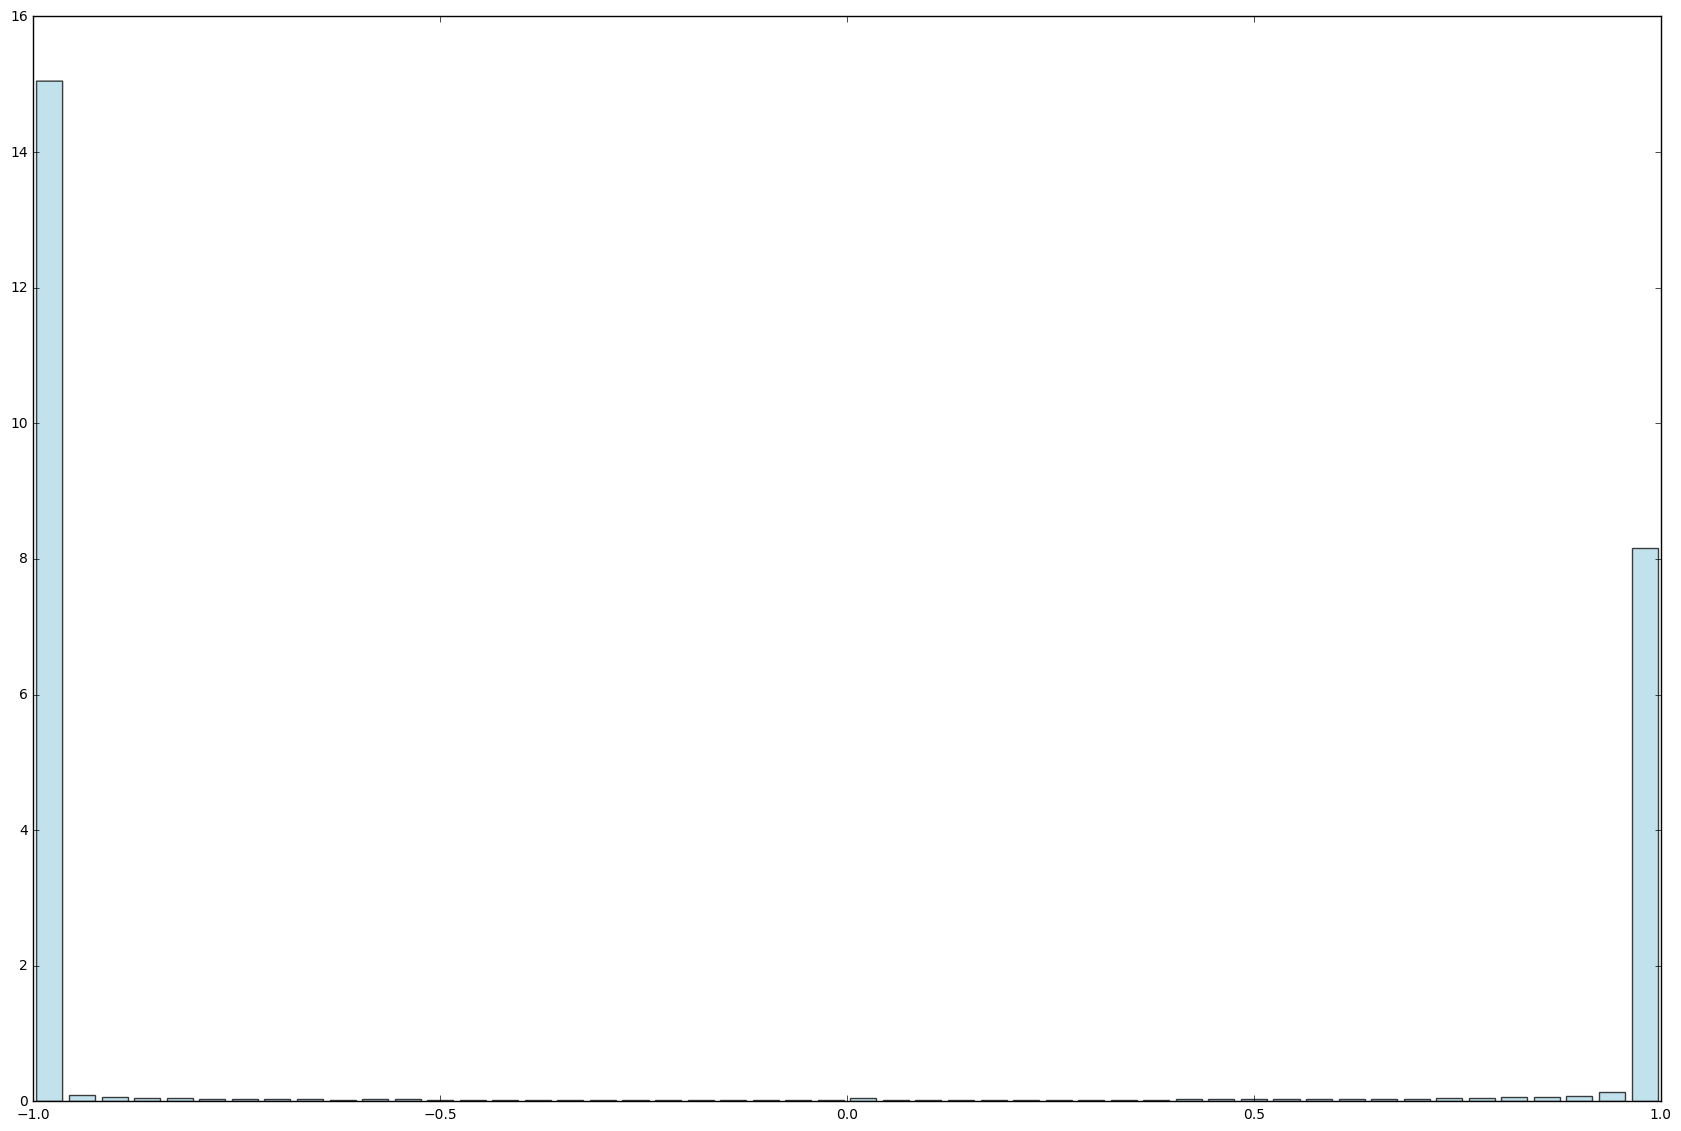

In [66]:
## plot the overall distribution of names by index
n, bins, patches = plot.hist(m_f['index'], 50, normed=1, histtype='bar', rwidth=0.8)
plot.setp(patches, 'facecolor', 'lightblue', 'alpha', 0.75);

In [67]:
## look at the ambiguous names
ambig_index = list(m_f[(m_f['index']>-1) & (m_f['index'] < 1)].iloc[:,6])
ambig_index[:2], ambig_index[-2:]

([0.99762920815552392, 0.9559228650137741],
 [0.59603658536585369, 0.57333333333333336])

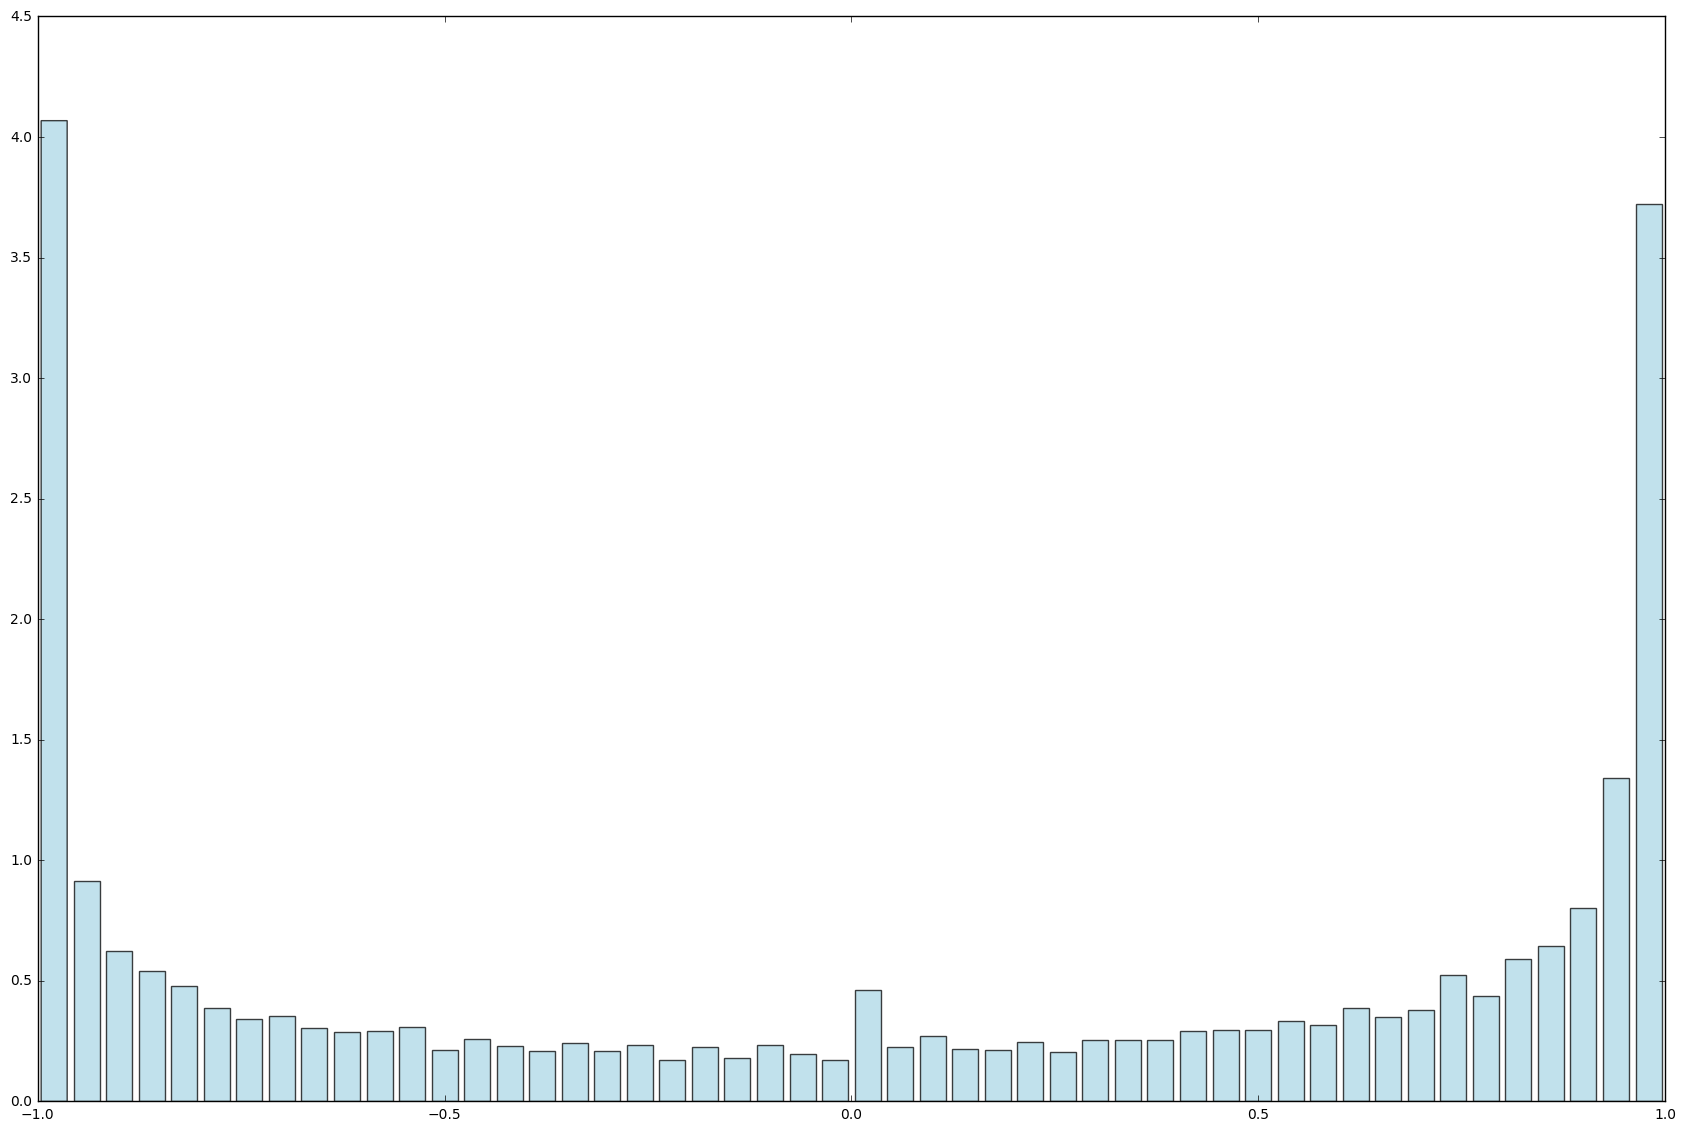

In [68]:
## plot distribution of ambiguous name indices
n, bins, patches = plot.hist(ambig_index, 50, normed=1, histtype='bar', rwidth=0.8)
plot.setp(patches, 'facecolor', 'lightblue', 'alpha', 0.75);

In [69]:
## of the 9K ambiguous names, most (7K) have a >.5 prob of being either M or F 
len([index for index in ambig_index if index < -.5]), len([index for index in ambig_index if index > .5])

(3327, 3678)

In [70]:
## create our own corpus of SS names including the gender and index
namesList = m_f.iloc[:,[0,6,7]]

In [71]:
namesList.head()

,name,index,gender
0,Aaban,1.0,male
1,Aabid,1.0,male
2,Aadam,1.0,male
3,Aadan,1.0,male
4,Aadarsh,1.0,male


In [72]:
## check for duplicates; find none
search = pd.DataFrame.duplicated(namesList)
print search[search == True][:9]

Series([], dtype: bool)


In [73]:
## make our own name list so we can build features in nltk
namesList2 = [tuple(x) for x in namesList.to_records(index=False)]

In [74]:
## check it
namesList2[-5:]

[('Zyriel', -1.0, u'female'),
 ('Zyrielle', -1.0, u'female'),
 ('Zyrihanna', -1.0, u'female'),
 ('Zyriyah', -1.0, u'female'),
 ('Zyyanna', -1.0, u'female')]

In [75]:
len(namesList2)

88860